In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchwi import Tomo2d
from Net import Tomography_CNN
from torch.optim.lr_scheduler import MultiplicativeLR
import time
import copy

In [4]:
import sys
from pathlib import Path
from pkrh.torchwi import param_selector, get_land_mask

In [5]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.13.0  Device: cuda


In [6]:
nx=320
ny=50
nshot=200
h=0.1
shotskip=2

In [7]:
#pluto velocity range 1.5~4.5
#congo velocity range 1.5~5.0
#gom data velocity range 1.5~5.0

In [8]:
sxs = (104 + np.arange(nshot))*h
sy = 0.
ry = 0.

In [9]:
rx = np.zeros((nshot,2),dtype=np.int32)

for ishot in range(nshot):
    rx[ishot,0] = 2 + ishot
    rx[ishot,1] = rx[ishot,0] + 100

In [10]:
print("nshot=%d, sy=%s, ry=%s"%(nshot,sy,ry))

nshot=200, sy=0.0, ry=0.0


In [11]:
rcv_mask = np.zeros((nshot,nx),dtype=bool)

for ishot in range(nshot):
    ir0 = rx[ishot,0]
    ir1 = rx[ishot,1]
    rcv_mask[ishot,ir0:ir1] = True

In [12]:
rcv_mask = torch.from_numpy(rcv_mask).cuda()

In [13]:
tomo = Tomo2d(nx,ny,h,device='cuda')
freq = 0.05
vmean = 3.0

In [14]:
#ttime_obs = np.fromfile("congo_input.bin",dtype=np.float32)
#ttime_obs.shape=(1,1,nx,nshot)
ttime_obs = np.fromfile("ttime_congo.bin",dtype=np.float32)
ttime_obs.shape=(1,1,nx,nshot)

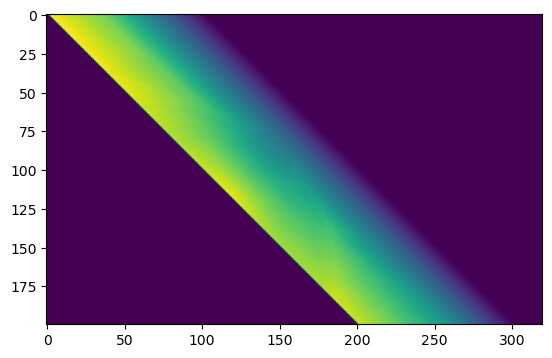

In [15]:
plt.imshow(ttime_obs[0].T)

In [16]:
ttime_obs = torch.from_numpy(ttime_obs)

In [17]:
ttime_obs.shape

torch.Size([1, 1, 320, 200])

In [18]:
PATH = "./weights/Tomography_CNN.pt"

In [19]:
model = torch.nn.DataParallel(Tomography_CNN().cuda(), device_ids=[0, 1, 2, 3])
#model = Tomography_CNN()

model.load_state_dict(torch.load(PATH))
#model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [20]:
def perc_clip_val(data,perc=100):
    # return clipping value by percent clip, does not apply clipping
    # data: array to clip
    # perc: percent value
    # output: min/max clip values
    mperc=(100.-perc)*0.01*0.5
    tmp=np.sort(data.flatten())
    minloc=int(len(tmp)*mperc)
    maxloc=len(tmp)-minloc-1
    clipmin=tmp[minloc]
    clipmax=tmp[maxloc]
    return clipmin,clipmax

In [21]:
def make_plot(prediction, perc=97):
    #clipmin,clipmax = perc_clip_val(x, perc)
    plt.figure(figsize=[16,3])
    # input seismogram - one shotgather
    #plt.subplot(1,3,1)
    #plt.imshow(np.clip(x,clipmin,clipmax), aspect='auto',cmap='gray_r')
    # true velocity model
    #plt.subplot(1,2,1)
    #plt.imshow(y.T, vmin=1.5, vmax=5.0)
    # predicted velocity model
    plt.subplot(1,2,2)
    plt.imshow(prediction.detach().numpy().T, vmin=1.5, vmax=5.0)
    plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
    plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
    plt.xlabel("Distance (km)",fontsize=10)
    plt.ylabel("Depth (km)",fontsize=8)
    plt.colorbar(shrink=0.325, aspect=10, pad=0.01, label="km/s")

In [22]:
def plot_prediction(model, ibatch=0):
    since = time.time()
    model.eval()
    
    with torch.no_grad():
        image = ttime_obs.cuda()
        output = model(image)
        make_plot(output[ibatch].cpu())
        output.detach().cpu().numpy().astype(np.float32).tofile("pred_congo.bin")
    
    time_elapsed = time.time() - since
    print('Total time elapesd of test data {:.4f}ms'.format(time_elapsed))
    return output

In [23]:
def evaluate(model):
    model.eval()
    
    alpha = 2*np.pi/(20*h)*vmean
    omega = 2.*np.pi*freq - alpha * 1.0j
    
    test_loss = 0.0

    with torch.no_grad():
        image, label = ttime_obs.cuda(), ttime_obs.cuda()
        output = model(image)
        output = output.reshape(nx,ny)
        
        tomo = Tomo2d(nx,ny,h,device='cuda')
        tomo.factorize(omega, output)
        ttime = tomo.forward(output, torch.from_numpy(sxs).cuda(), sy, ry) * rcv_mask
        masked_t = ttime.transpose(0,1)
        masked_t = masked_t.reshape(1,1,nx,nshot)
        
        #loss = torch.sum(abs(masked_t - image))/(nshot*100)
        loss = F.l1_loss(masked_t, label) * 3.2
        test_loss += loss.detach()
        
        tomo.finalize()
    
    print('Tr MAE: {:.6f}'.format(test_loss))
    return test_loss

Total time elapesd of test data 1.7098ms


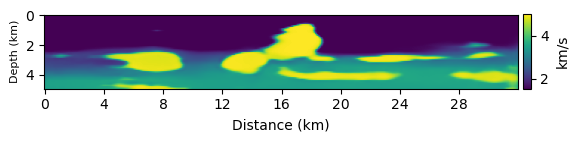

In [24]:
pred_init = plot_prediction(model, ibatch=0)

In [25]:
test_loss = evaluate(model)

Tr MAE: 0.143402


In [26]:
def plot_traveltime(ttime_obs, vel_dl):
    
    alpha = 2*np.pi/(20*h)*vmean
    omega = 2.*np.pi*freq - alpha * 1.0j
    
    tomo = Tomo2d(nx,ny,h,device='cuda')
    tomo.factorize(omega, vel_dl())
    ttime_dl = tomo.forward(vel_dl(), torch.from_numpy(sxs).cuda(), sy, ry) * rcv_mask
    
    plt.figure(figsize=[12,4])
    plt.xlabel('Distance (km)', fontsize=15)
    plt.ylabel('Time (s)', fontsize=15)
    plt.plot(ax[ttime_obs[0]>0], ttime_obs[0,ttime_obs[0]>0], "r-", label="Observed")
    plt.plot(ax[ttime_dl[0].detach().cpu().numpy()>0], ttime_dl[0,ttime_dl[0]>0].detach().cpu().numpy(), "c-.", label="Modeled_dl")
    plt.legend(loc="upper right")
    
    plt.plot(ax[ttime_obs[49]>0], ttime_obs[49,ttime_obs[49]>0], "r-", label="Observed")
    plt.plot(ax[ttime_dl[49].detach().cpu().numpy()>0], ttime_dl[49,ttime_dl[49]>0].detach().cpu().numpy(), "c-.", label="Modeled_dl")
    
    plt.plot(ax[ttime_obs[99]>0], ttime_obs[99,ttime_obs[99]>0], "r-", label="Observed")
    plt.plot(ax[ttime_dl[99].detach().cpu().numpy()>0], ttime_dl[99,ttime_dl[99]>0].detach().cpu().numpy(), "c-.", label="Modeled_dl")
   
    plt.plot(ax[ttime_obs[149]>0], ttime_obs[149,ttime_obs[149]>0], "r-", label="Observed")
    plt.plot(ax[ttime_dl[149].detach().cpu().numpy()>0], ttime_dl[149,ttime_dl[149]>0].detach().cpu().numpy(), "c-.", label="Modeled_dl")
    
    plt.plot(ax[ttime_obs[199]>0], ttime_obs[199,ttime_obs[199]>0], "r-", label="Observed")
    plt.plot(ax[ttime_dl[199].detach().cpu().numpy()>0], ttime_dl[199,ttime_dl[199]>0].detach().cpu().numpy(), "c-.", label="Modeled_dl")
    plt.xticks(np.arange(0, 320, 50), np.arange(0, 32, 5))

In [27]:
prediction = np.fromfile("pred_congo.bin",dtype=np.float32)
prediction.shape = (nx,ny)

In [28]:
ttime_obs = np.fromfile("ttime_congo.bin",dtype=np.float32)
ttime_obs.shape=(nx,nshot)

In [29]:
ttime_obs = ttime_obs.T

In [30]:
ttime_obs.shape

(200, 320)

In [31]:
vmin = 1.5
vmax = 5.0
ax = np.arange(0, 320)

In [32]:
vel_dl = param_selector('velocity',prediction,vmin,vmax)

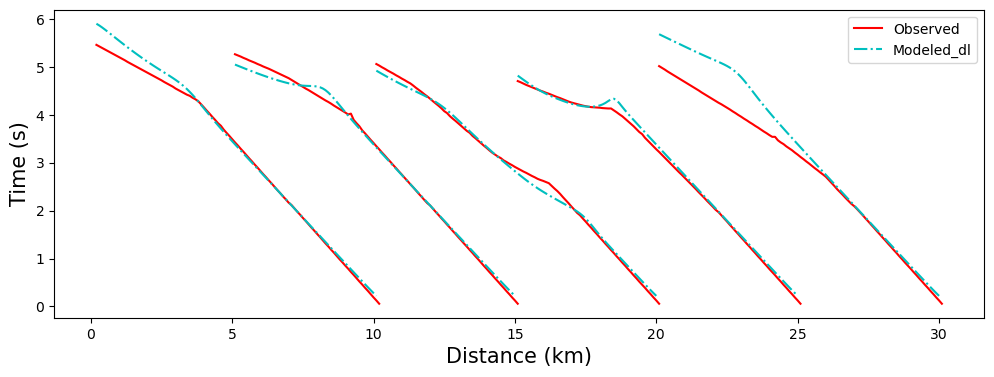

In [33]:
plot_traveltime(ttime_obs, vel_dl)